# Добро пожаловать на задание уровня Ultra Pro.

В данном задании требуется на базе клеток сделать задачу сегментации с вниманием.

Хотелось бы отметить что данное задание является сложным и Вам потребуется самостоятельно разобраться как правильно включить блок внимания в задачу сегментации.


Успехов!

In [1]:
# Загрузить библиотеку OpenCV для загрузки файлов
import cv2

# Загрузим библиотеку Numpy
import numpy as np

# # Импортируем модель для загрузки файлов
from glob import glob

#
from matplotlib import pylab as plt

# Импортируем слои
from keras.layers import Conv2D, BatchNormalization, Activation, Dropout, UpSampling2D, Add, Multiply, Input, Concatenate, MaxPooling2D

# Импортируем Model
from keras.models import Model

# Импортируем оптимизатор
from tensorflow.keras.optimizers import Adam

# Импортируем backend keras
from keras import backend as K

In [2]:
# Подключаем диск
import gdown
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/advanced/l4/cellbase.zip', None, quiet=True)

'cellbase.zip'

In [53]:
# Распаковываем zip-файл базы
!unzip -q -o 'cellbase.zip'

In [4]:
!rm -f -r /content/SegmentationWithAttention

In [5]:
!git clone https://github.com/Vafelka1/SegmentationWithAttention

Cloning into 'SegmentationWithAttention'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 84 (delta 22), reused 0 (delta 0), pack-reused 40
Receiving objects: 100% (84/84), 72.20 MiB | 26.11 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [287]:
from PIL import Image
import os
def change_image_extension(img_fold,label_fold):
  for item in sorted(os.listdir(img_fold)):
    path = f"{img_fold}/{item}"
    img = Image.open(path)
    new_path = path.split('.')[0]+'.jpg'
    os.remove(path)
    img.save(new_path)

  for item in sorted(os.listdir(label_fold)):
    path = f"{label_fold}/{item}"
    img = Image.open(path)
    new_path = path.split('.')[0]+'.jpg'
    os.remove(path)
    img.save(new_path)


change_image_extension('train','label')

In [6]:
from __future__ import print_function, division
import os
import math
from os.path import join, exists
from keras import callbacks
# local libs
from SegmentationWithAttention.materials.models.suim_net import SUIM_Net

In [69]:
dataset_name = "suim"
train_dir = "/content"

In [8]:
ckpt_dir = "/content/SegmentationWithAttention/materials/models/weights"
base_ = 'RSB' # or 'VGG'
if base_=='RSB':
    im_res_ = (320, 240, 3)
    ckpt_name = "suimnet_rsb02.hdf5"
else:
    im_res_ = (320, 256, 3)
    ckpt_name = "suimnet_vgg.hdf5"
model_ckpt_name = join(ckpt_dir, ckpt_name)
if not exists(ckpt_dir): os.makedirs(ckpt_dir)

In [9]:
from keras.layers import UpSampling2D, Conv2D

In [249]:
suimnet = SUIM_Net(base=base_, im_res=im_res_, n_classes=1)
model = suimnet.model
print (model.summary())

Triplet Attention!
ATTENTION!


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 240, 320, 3)]        0         []                            
                                                                                                  
 conv2d_108 (Conv2D)         (None, 236, 316, 64)         4864      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_105 (B  (None, 236, 316, 64)         256       ['conv2d_108[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_66 (Activation)  (None, 236, 316, 64)         0         ['batch_normalization_10

In [11]:
batch_size = 4
num_epochs = 40

In [217]:

# setup data generator
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

In [218]:
model_checkpoint = callbacks.ModelCheckpoint(model_ckpt_name,
                                   monitor = 'loss',
                                   verbose = 1, mode= 'auto',
                                   save_weights_only = True,
                                   save_best_only = True)

In [314]:
def getSaliency(mask):
    # one combined category: HD/RO/FV/WR
    imw, imh = mask.shape[0], mask.shape[1]
    sal = np.zeros((imw, imh))
    for i in range(imw):
        for j in range(imh):
            if (mask[i,j,0]<=125 and mask[i,j,1]<=125 and mask[i,j,2]<=125):
                sal[i, j] = 1
            elif (mask[i,j,0]>=125 and mask[i,j,1]>=125 and mask[i,j,2]>=125):
                sal[i, j] = 1
            else: pass
    return np.expand_dims(sal, axis=-1)

In [145]:
#def getSaliency(mask):
#    # one combined category: HD/RO/FV/WR
#    imw, imh = mask.shape[0], mask.shape[1]
#    sal = np.zeros((imw, imh))
#    for i in range(imw):
#       for j in range(imh):
#           if j<=0.5:
#               sal[i, j] = 0
#           elif j>=5.:
#               sal[i, j] = 1
#           else: pass
#   return np.expand_dims(sal, axis=-1)

In [321]:
def processSUIMDataRFHW(img, mask, sal=True):
    # scaling image data and masks
    #mask = mask / 255

    m = []
    for i in range(mask.shape[0]):
        if sal:
            m.append(getSaliency(mask[i]))
        else:
            print('Миша,давай по новой')
    m = np.array(m)
    return (img, m)

In [319]:
from keras.preprocessing.image import ImageDataGenerator
def trainDataGenerator(batch_size, train_path, image_folder, mask_folder, aug_dict, image_color_mode="grayscale",
                    mask_color_mode="grayscale", target_size=(256,256), sal=True):
    # data generator function for driving the training
    image_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = None,
        save_prefix  = "image",
        seed=1)
    # mask generator function for corresponding ground truth
    mask_datagen = ImageDataGenerator(**aug_dict)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = None,
        save_prefix  = "mask",
        seed = 1)
    # make pairs and return
    for (img, mask) in zip(image_generator, mask_generator):
        img, mask_indiv = processSUIMDataRFHW(img, mask, sal)
        #yield (img, mask_indiv)
        #print(img.shape)
        #print(mask_indiv)
        print(np.count_nonzero(mask_indiv))

In [320]:
# data generator

train_gen = trainDataGenerator(batch_size, # batch_size
                              train_dir,# train-data dir
                              "train", # image_folder
                              "label", # mask_folder
                              data_gen_args, # aug_dict
                              image_color_mode="rgb",
                              mask_color_mode="rgb",
                              target_size = (im_res_[1], im_res_[0]))

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
307200
307200


KeyboardInterrupt: ignored

In [250]:
num_epochs = 1

suimnet2 = model.fit(train_gen,
                    steps_per_epoch = 10,
                    epochs = num_epochs,
                    callbacks = [model_checkpoint])

10/10 [==============================] - ETA: 0s - loss: 0.7285 - accuracy: 0.6467
Epoch 1: loss did not improve from 0.00083
10/10 [==============================] - 24s 297ms/step - loss: 0.7285 - accuracy: 0.6467


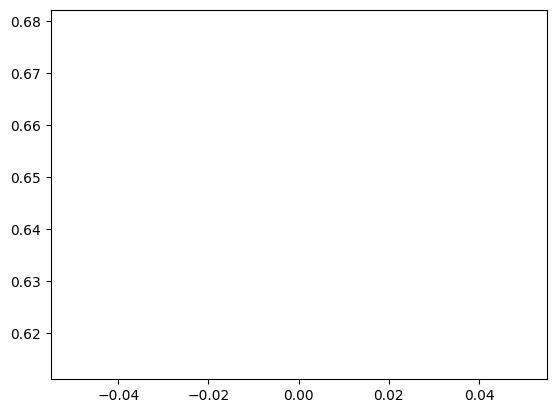

In [252]:
import matplotlib.pyplot as plt
plt.plot(suimnet2.history['accuracy'])

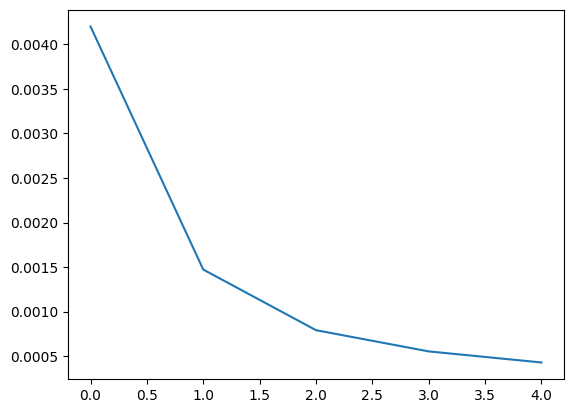

In [156]:
plt.plot(suimnet2.history['loss'])

In [253]:
def change_image_extension(test_fold):
  for item in sorted(os.listdir(test_fold)):
    path = f"{test_fold}/{item}"
    img = Image.open(path)
    new_path = path.split('.')[0]+'.jpg'
    os.remove(path)
    img.save(new_path)
change_image_extension('test')

In [257]:
im = Image.open('/content/label/2.jpg')
im = im.convert('RGB')
im = im.resize((320, 240))
im = np.array(im)
im = np.expand_dims(im, axis=0)

In [258]:
im.shape

(1, 240, 320, 3)

In [259]:
ans = model.predict(im)
answer = ans.astype('int8')
answer = np.squeeze(answer,axis=0)

1/1 [==============================] - 1s 895ms/step


In [260]:
np.unique(answer)

array([0, 1], dtype=int8)

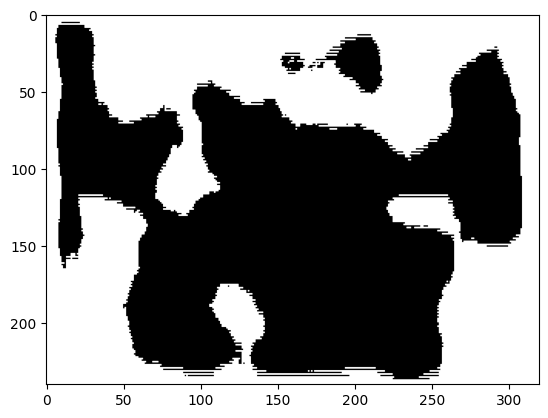

In [261]:
plt.imshow(answer, cmap='Greys')

In [312]:
im = Image.open('/content/label/2.jpg')
im = im.convert('RGB')
im = np.array(im)
im

array([[[254, 254, 254],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [245, 245, 245],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [249, 249, 249],
        [249, 249, 249],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [236, 236, 236],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[250, 250, 250],
        [255, 255, 255],
        [240, 240, 240],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [249, 249, 249],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]